# Solving for the Anistropic risk

This notebook provides code to solve the system of ODEs describing the risk of SGD under gradient clipping. The code works for both isotropic and anisotropic setups; however simpler implementations exist for isotropy.


To reproduce the figures, simply run everything. The "define plot parameters" simply sets the style for the plots so you may wish to comment that out.







# Define plot parameters

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

import matplotlib.font_manager as fm
import matplotlib.ft2font as ft
import matplotlib

from matplotlib import rc
import seaborn as sns




sns.set_style('ticks')
sns.set_context('paper', font_scale=2.25)
fig_dict = {
    'figsize':[8.0, 6.0],
}
math_dict = {
    'fontset': 'cm',
}
legend_dict = {
    'fontsize': 20,
    'markerscale': 2.7,
}
savefig_dict = {
    'bbox': 'tight',
    'transparent': 'True',
    'pad_inches': 0.1,
}
axes_dict = {
    'titlesize': '20',
    'titlepad': '5.5',
    'labelsize': '25',
    'labelpad': '7',
    'formatter.use_mathtext' : 'True'
}
lines_dict = {
    'linewidth': 2.7,
}

rc('figure', **fig_dict)
rc('mathtext', **math_dict)
rc('legend', **legend_dict)
rc('savefig', **savefig_dict)
rc('axes', **axes_dict)
rc('lines', **lines_dict)

from matplotlib.font_manager import FontProperties

f_name = '/Users/ruth/Helvetica/helvetica_regular.ttf'
fm.fontManager.addfont(f_name)
font = ft.FT2Font(f_name)

custom_font = FontProperties(fname= f_name)

matplotlib.rcParams['font.sans-serif'].insert(0, font.family_name)
matplotlib.rcParams['font.family'] = font.family_name

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define functions

In [ ]:
import numpy as np
import scipy
from numpy.linalg import norm
from scipy.stats import norm as normal
from scipy.special import erf
from scipy.special import erfc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy import stats
import scipy
tpdf = stats.t.pdf
import numpy as np
import matplotlib.pyplot as plt

def risk(K,x,beta):
    return (x-beta).transpose() @ K @ (x-beta)/2

def clip(x,c):
    if len(x.shape) > 1:
        raise Exception("You need to clip a matrix")
    k = np.minimum(1, c / norm(x))
    return k * x

def clip_matrix(x,c):
    return np.minimum(1, c / norm(x, axis = 1))[:,None] * x


def one_pass_sgd(K,A,y, x):
    r = []
    times = []

    for i,(a,b) in enumerate(zip(A,y)):
        if i % 20 == 0:
            times.append(i)
            r.append(risk(K,x,beta))

        grad = (np.dot(x,a) - b) * a

        if ck > 0:
            grad = clip(grad, ck)

        x = x - gammak * grad

    times.append(i+1)
    r.append(risk(K,x,beta))
    return np.array(r), np.array(times)


def hsgd_ode(vals,vecs,T,x0,beta,gamma,c):

    dt = 0.05
    v = ((x0-beta) @ U)**2 / 2
    R = np.dot(vals,v)
    Rs = [R]

    ode_time = [0]
    iters = int(T / dt)
    for i in range(iters + 1):
        t = i * dt
        R = np.dot(vals,v)

        update = -gamma * 2 * v * vals* G_GAU(R,eta,c) + gamma**2 * (vals * G_STU(R,eta,c) * (2*R+ eta**2)) / 2 / d

        v = v + dt * update

        ode_time.append(t)
        Rs.append(R)
    return np.array(Rs), ode_time

def hsgd_ode_stu_t(vals,vecs,T,x0,beta,gamma,c):

    dt = 0.05
    v = ((x0-beta) @ U)**2 / 2
    R = np.dot(vals,v)
    Rs = [R]

    ode_time = [0]
    iters = int(T / dt)
    for i in range(iters + 1):
        t = i * dt
        R = np.dot(vals,v)

        update = -gamma * 2 * v * vals* H_STU(R,scale,df,c) + gamma**2 * (vals * G_STU(R,scale,df,c)) / 2 / d

        v = v + dt * update

        ode_time.append(t)
        Rs.append(R)
    return np.array(Rs), ode_time

def clipped_hsgd(K, sqrtK, beta,T,x):
    dt = 0.01
    sqrtdt = np.sqrt(dt)
    N = int(T/dt)

    risks = []
    time = []

    for i in range(N):
        R = risk(K,x,beta)
        risks.append(R)
        time.append(dt * i)

        delta_B = np.random.randn(ambient_d) * sqrtdt

        gradP = K @ (x-beta)

        # x = x - gamma * gradP * H_STU(R,scale,df,c)*dt + gamma * np.sqrt(G_STU(R,scale,df,c) * (2*R + eta**2)/d) * sqrtK @ delta_B
        x = x - gamma * gradP * H_STU(R,scale,df,c)*dt + gamma * np.sqrt(G_STU(R,scale,df,c) /d) * sqrtK @ delta_B


    time.append(dt * N)
    risks.append(risk(K,x,beta))

    time = np.array(time)
    risks = np.array(risks)
    return risks, time

def F(z):
    return scipy.special.erf(z/np.sqrt(2)) - np.sqrt(2 / np.pi) * z * np.exp(-z**2 / 2)

def H_GAU(risk,eta,c):
    # Gaussian data gaussian noise with var eta**2
    risk = risk + eta**2/2
    return F(c / np.sqrt(2 * risk)) + c* np.exp(-c**2 / 4 / risk) / np.sqrt(3.1415 * risk)

def G_GAU(risk,eta,c):
    # Gaussian data gaussian noise with var eta**2
    varW = 2 * risk + eta**2
    risk = risk + eta**2/2

    return (2 * risk * F(c / np.sqrt(2 * risk)) + c**2 * erfc(c / np.sqrt(4 * risk))) / (varW)

def H_STU(risk,scale,df,c):
    # compute P(not clipping) for Gaussian data and student-t (with df degrees freedom) noise
    range = np.linspace(-c,c,200)
    pdf_vals = sum_pdf(range,risk,scale,df)

    return scipy.integrate.simpson(pdf_vals, x = range)

def G_STU(risk,scale,df,c):

    range = np.linspace(-c,c,200)
    pdf_vals = sum_pdf(range,risk,scale,df)

    integrand = range**2 * pdf_vals
    truncated_var = scipy.integrate.simpson(integrand, x = range)


    # compute P(clipping) = 1 - P(not clipping) = 1 - H_STU
    p_clip = 1 - H_STU(risk,scale,df,c)

    return (truncated_var + c**2 * p_clip)

def sum_pdf(x_values, risk, sigma, df):
    v = np.sqrt(2 * risk)
    v_sqrt_2pi = v * np.sqrt(2 * np.pi)

    # Precompute gau_pdf for the t_range
    t_range = np.linspace(-30 * sigma, 30 * sigma, 100)
    gau_values = np.exp(-0.5 * (t_range / v)**2) / v_sqrt_2pi

    # Prepare x_values as a 2D array for broadcasting
    x_values = np.atleast_2d(x_values).T

    # Compute t_pdf for each x_values - t_range in a vectorized manner
    t_pdf_values = tpdf(x_values - t_range, df, scale=sigma)

    # Calculate the integrand for all x_values
    integrand_values = gau_values * t_pdf_values

    # Integrate over t_range using Simpson's rule for all x_values
    results = scipy.integrate.simpson(integrand_values, x=t_range, axis=1)

    return results

## Making plots with Student-t distributions

The Student-t family ranges from Cauchy (df = 1) to Gaussian (as df goes to infinity). This makes a nice example to vary from very-heavy-tailed distribution to Gaussian tails.

In [ ]:
ambient_d = 500

# Generate covariance matrices
alpha = 1/5

U = scipy.stats.ortho_group.rvs(ambient_d)
sigmas = np.array([j**(-alpha) for j in range(1,ambient_d+1)])
K = U @ np.diag(sigmas) @ U.transpose()
sqrtK = U @ np.diag(np.sqrt(sigmas)) @ U.transpose()

c = 0.4
gamma = 0.6
T = 15

df = 1 # Cauchy data from student-t family
scale = 0.5

In [ ]:
 # Define dimension related values
d = np.trace(K)
print(f'Running with int. dim: {d}')

n = int(T * d)
ck = c * np.sqrt(d)
gammak = gamma / d
beta = np.ones(ambient_d) * 0
x0 = np.ones(ambient_d)
x0 /= norm(x0)


# Now run SGD
num_runs = 100
sgd_data = []
hsgd_data = []

# Get data and targets
data_for_sgd = []
for _ in tqdm(range(num_runs)):
    a = np.random.multivariate_normal(mean=np.zeros(ambient_d), cov = K, size = n)

    df = 1 # Cauchy data from student-t family
    scale = 0.5
    eps = stats.t.rvs(df, size=n, scale = scale)
    b = a @ beta + eps

    sgd_risk, sgd_times = one_pass_sgd(K,a,b,x0)
    sgd_data.append(sgd_risk)

    # hsgd_risk, hsgd_times = clipped_hsgd(K,sqrtK,beta,T,x0)
    # hsgd_data.append(hsgd_risk)
    # np.save('hsgd_data.num', hsgd_data)
# hsgd_data = np.load('/content/hsgd_data_100runs.npy')    

Running with int. dim: 179.7478276860984


  0%|          | 0/100 [00:00<?, ?it/s]

Plotting with d=179.7478276860984


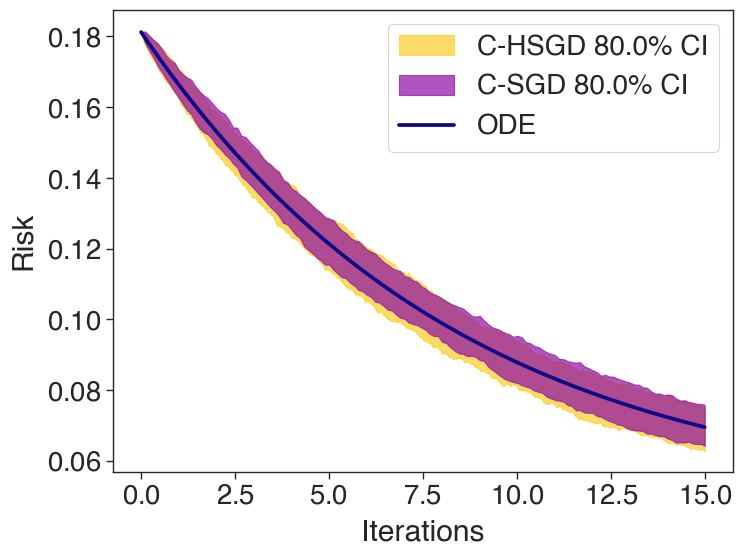

In [ ]:
confidence = 0.8
q_low = (1-confidence)/2
q_high = 1/2 + confidence/2

# Set the colormap
cmap = 'plasma'

idxs = np.linspace(0,1,4)
sgd_color = plt.get_cmap(cmap)(0.3)
hsgd_color = plt.get_cmap(cmap)(0.9)
clip_ode_color = plt.get_cmap(cmap)(1)
unclip_ode_color = clip_ode_color


sgd_low = np.quantile(sgd_data, q_low, axis = 0)
sgd_high = np.quantile(sgd_data, q_high, axis = 0)

hsgd_low = np.quantile(hsgd_data, q_low, axis = 0)
hsgd_high = np.quantile(hsgd_data, q_high, axis = 0)

## Plot results
# plt.fill_between(hsgd_times, hsgd_low, hsgd_high, alpha=0.7, color = hsgd_color)
plt.fill_between(sgd_times / d, sgd_low, sgd_high, alpha=0.7, color = sgd_color)

ode_risk, ode_time = hsgd_ode_stu_t(sigmas, U, T, x0, beta,gamma, c)
# ode_risk_no_clip, ode_time = hsgd_ode(sigmas, U, T, x0, beta, gamma, c = 10000000) # c is effectivly infinite

print(f'Plotting with d={d}')
plt.plot(ode_time, ode_risk, color = clip_ode_color)
# plt.plot(ode_time, ode_risk_no_clip, '--', color=unclip_ode_color) ## Uncomment for Gaussian

plt.legend([f'C-HSGD {confidence*100}% CI',f'C-SGD {confidence*100}% CI', 'ODE'])
plt.xlabel('Iterations', fontproperties=custom_font)
plt.ylabel('Risk', fontproperties=custom_font)


name = f"df_{df}_sgd_vs_hsgd_ambient500_d{d}_powerlaw_{alpha}_clip_{c}_gamma_{gamma}_scale_{scale}.pdf"
plt.savefig(name, format = 'pdf')
plt.show()